# Integrated Simulations

In [1]:
# To manipulate arrays
import pandas as pd
import pathlib
import sys
import numpy as np
from pathlib import Path
import tifffile
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt 
# Plotting
current_dir = pathlib.Path().absolute()
rsnaped_dir = current_dir.parents[0].joinpath('rsnaped')
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [2]:
case = 0

if case == 0:
    selected_video = 0 # 0 is the only move with multiple cells
    video_dir = current_dir.parents[0].joinpath('/home/luisub/Desktop/rsnaped/DataBases/KDM5B_Translation_SampleMovies')
    path_files, list_files_paths, list_videos, num_videos = rsp.Utilities.read_files_in_directory(directory=video_dir, extension_of_files_to_look_for = 'tif',return_images_in_list=True)
    image_optimization = list_videos[selected_video] 
    image_optimization = rsp.ConvertToStandardFormat(video=image_optimization, time_position = 0, height_position = 2,  width_position = 3, channel_position = 1 ).transpose_video()
    image_optimization = image_optimization[0:100,:,:,1]
    # Create 3 copies of the array
    red_channel = image_optimization.copy()
    green_channel = image_optimization.copy()
    blue_channel = image_optimization.copy()
    # Stack them along a new dimension
    video = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    particle_detection_size =   7               # spot size for the simulation and tracking.
    average_cell_diameter = 300                    # cell diameter
    min_percentage_time_tracking = 0.3            # (normalized) minimum time to consider a trajectory.

elif case == 1:
    selected_video = 1 # 0-4
    video_dir = current_dir.parents[0].joinpath('DataBases','Jacks_Data')
    path_files, list_files_paths, list_videos, num_videos = rsp.Utilities.read_files_in_directory(directory=video_dir, extension_of_files_to_look_for = 'tif',return_images_in_list=True)
    image_optimization = list_videos[0][:,selected_video,:,:]
    # Create 3 copies of the array
    red_channel = image_optimization.copy()
    green_channel = image_optimization.copy()
    blue_channel = image_optimization.copy()
    # Stack them along a new dimension
    video = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    particle_detection_size =  5               # spot size for the simulation and tracking.
    average_cell_diameter = 120                    # cell diameter
    min_percentage_time_tracking = 0.15            # (normalized) minimum time to consider a trajectory.

# Print the shape of the video
print(image_optimization.shape)
print(np.max(image_optimization))

The video has been transposed to the format [T, Y, X, C] and the channels are RGB
(100, 512, 512)
14412


In [3]:
list_files_paths[0]

'BLC_BG_MAX_Cell_01_4mW561_10mW637.tif'

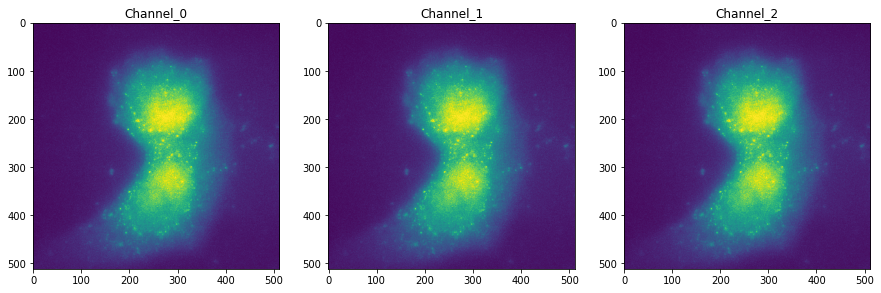

In [4]:
rsp.Plots.plot_image_channels(video,selected_time_point = 0)


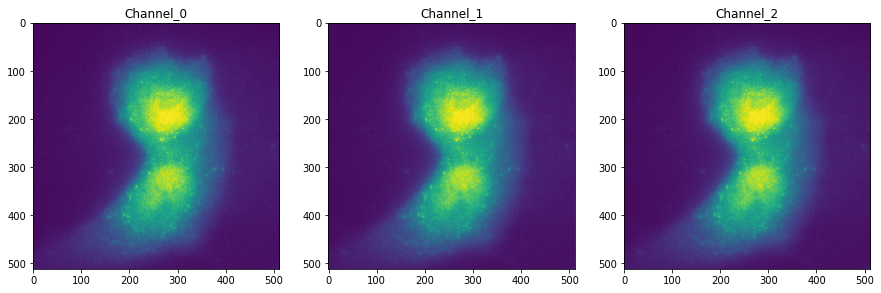

In [5]:
rsp.Plots.plot_image_channels(video,selected_time_point = -1)


In [6]:
# make a new directory with correct format
video_dir_std = Path(video_dir,'standard_format')
video_dir_std.mkdir(exist_ok=True)
# save as a tif file
tifffile.imsave(str(video_dir_std.joinpath('std_'+list_files_paths[0])), video, metadata={'axes': 'TYXC'})

# Tracking

In [7]:
selected_channel_tracking = 0
selected_channel_segmentation = 1
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'all_cells_in_image'           # options are : 'all_cells_in_image', 'max_spots' and 'max_area' 
use_optimization_for_tracking = 1            # 0 not using, 1 is using optimization
#min_percentage_time_tracking = 0.1            # (normalized) minimum time to consider a trajectory.
#particle_detection_size =   7               # spot size for the simulation and tracking.
#average_cell_diameter = 300                    # cell diameter
intensity_threshold_tracking = None          # intensity threshold. If None, the code uses automatic detection # 
real_positions_dataframe = None #pd.read_csv(video_dir.joinpath('both_base_pb_KDM5B_P300_0.06_5.33333_video_cell_0.csv'))
create_metadata= False
create_pdf=True
intensity_threshold_tracking= None
dataframe_format='long'

100%|██████████| 25.3M/25.3M [00:00<00:00, 29.1MB/s]
100%|██████████| 5.23k/5.23k [00:00<00:00, 15.7MB/s]


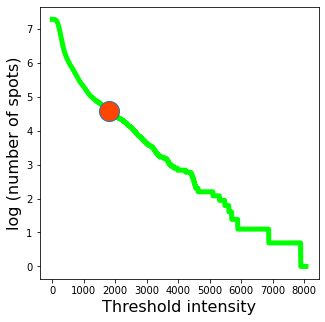

The number of detected trajectories is:  19
The selected intensity threshold is:  1815.0 



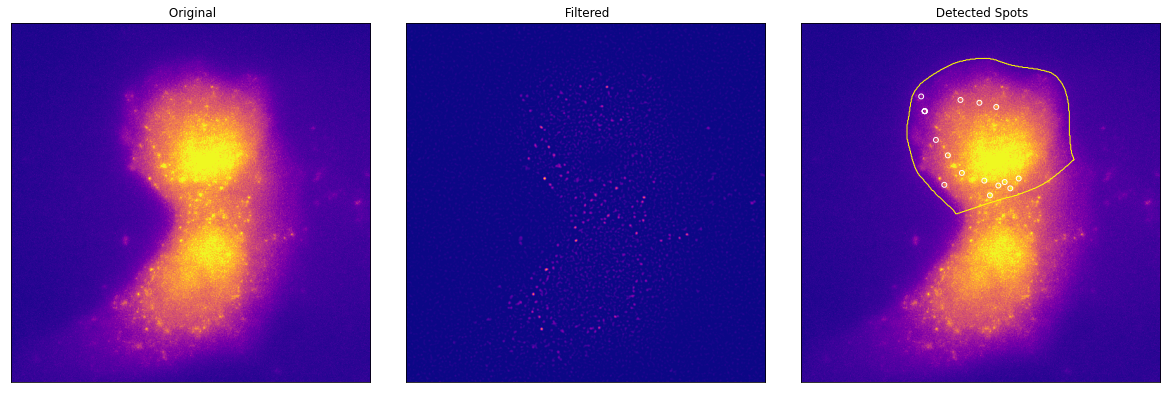

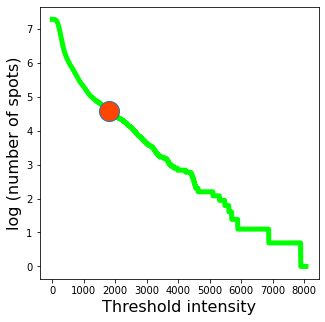

The number of detected trajectories is:  31
The selected intensity threshold is:  1815.0 



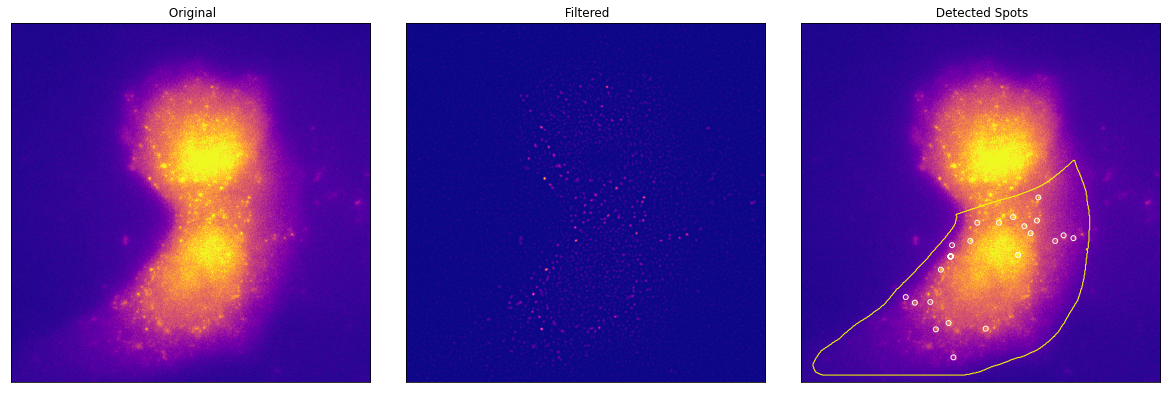

In [8]:
list_DataFrame_tracking, list_array_intensities, list_time_vector, list_selected_mask = rsp.image_processing(video=video, 
                                                                                                            #files_dir_path_processing=video_dir_std,
                                                                                                            particle_size=particle_detection_size,
                                                                                                            selected_channel_tracking = selected_channel_tracking,
                                                                                                            selected_channel_segmentation = selected_channel_segmentation,
                                                                                                            intensity_calculation_method =intensity_calculation_method, 
                                                                                                            intensity_threshold_tracking=intensity_threshold_tracking,
                                                                                                            mask_selection_method = mask_selection_method,
                                                                                                            show_plot=True,
                                                                                                            use_optimization_for_tracking=use_optimization_for_tracking,
                                                                                                            real_positions_dataframe = real_positions_dataframe,
                                                                                                            average_cell_diameter=average_cell_diameter,
                                                                                                            print_process_times=False,
                                                                                                            min_percentage_time_tracking=min_percentage_time_tracking,
                                                                                                            create_pdf=create_pdf,
                                                                                                            create_metadata=create_metadata,
                                                                                                            dataframe_format=dataframe_format)

In [9]:
df =list_DataFrame_tracking[0]

In [10]:
#df=pd.read_csv('/home/luisub/Desktop/rsnaped/notebooks_final/old_code.csv')

In [11]:
def plot_scatter_spots_cell_size(x,y,plot_title,selected_color = '#1C00FE',xlabel='',ylabel=''):
    r, p = stats.pearsonr(x, y)
    df_join_distribution = pd.DataFrame({'X':x,'Y':y})
    #plt.figure(figsize=(6,5))
    sns.set(font_scale = 1.3)
    b = sns.jointplot(data=df_join_distribution, y='Y', x='X', color= selected_color , marginal_kws=dict(bins=40, rug=True))
    b.plot_joint(sns.rugplot, height=0, color=[0.7,0.7,0.7], clip_on=True)
    b.plot_joint(sns.kdeplot, color=[0.5,0.5,0.5], levels=5)
    b.plot_joint(sns.regplot,scatter_kws={'color': 'orangered',"s":10, 'marker':'o'}, line_kws={'color': selected_color,'lw': 2} )
    blank_plot, = b.ax_joint.plot([], [], linestyle="", alpha=0)
    b.ax_joint.legend([blank_plot],['r={:.2f}'.format( np.round(r,2))],loc='upper left',)
    b.ax_joint.set_xlim(np.percentile(x,1), np.percentile(x,99))
    b.ax_joint.set_ylim(np.percentile(y,1), np.percentile(y,99))
    b.fig.suptitle(plot_title)
    b.ax_joint.set_xlabel(xlabel)
    b.ax_joint.set_ylabel(ylabel)
    b.ax_joint.collections[0].set_alpha(0)
    b.fig.tight_layout()
    b.fig.subplots_adjust(top=0.92) 
    #name_plot = plot_title +'.pdf'  
    #plt.savefig(name_plot, transparent=False,dpi=1200, bbox_inches = 'tight', format='pdf')
    plt.show()
    #pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
    return

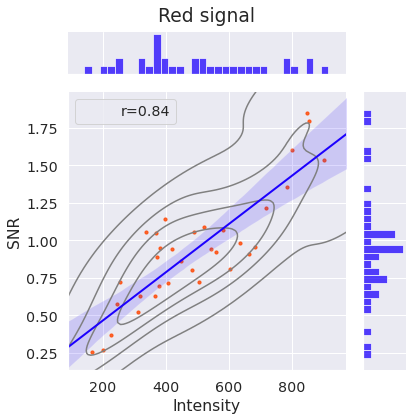

In [12]:

# Scatter plots intensity comparing all channels # ch1_bg_int_std #ch1_SNR
SNR = rsp.Utilities.extract_field_from_dataframe(dataframe=df,selected_time=0,selected_field='ch0_SNR').astype(float)
intensity = rsp.Utilities.extract_field_from_dataframe(dataframe=df,selected_time=0,selected_field='ch0_int_mean').astype(float)
plot_scatter_spots_cell_size(intensity,SNR,plot_title='Red signal',selected_color = '#1C00FE',xlabel='Intensity',ylabel='SNR')


In [13]:
#total_particles = 0
list_num_particles = []
for image_id in set(df['image_number']):
    for cell in set(df[df['image_number'] == image_id]['cell_number'] ):
        total_particles = len(set(df[ (df['image_number'] == image_id) & ( df['cell_number'] == cell) ]   ['particle'] ))
        print('particles in cell',str(cell),' : ',total_particles)
        list_num_particles.append(total_particles)

particles in cell 0  :  19
particles in cell 1  :  31


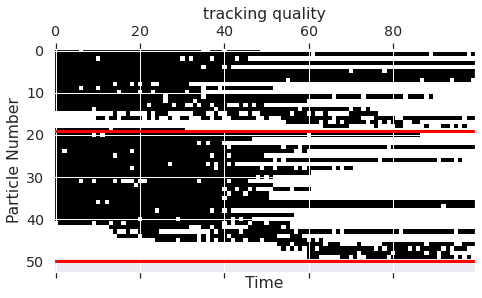

In [14]:
ch0_int_mean = rsp.Utilities.extract_field_from_dataframe(dataframe=df,selected_time=None,selected_field='ch0_int_mean')
temp = np.where(ch0_int_mean > 0, 1, 0)

plt.matshow(~temp, cmap='gray')
plt.title('tracking quality')   
plt.xlabel('Time')
plt.ylabel('Particle Number')
for i in range(len(list_num_particles)):
    if i > 0:
        plt.axhline(y=list_num_particles[i]+list_num_particles[i-1], color='red', linewidth=3)
    else:
        plt.axhline(y=list_num_particles[i], color='red', linewidth=3)
plt.show()

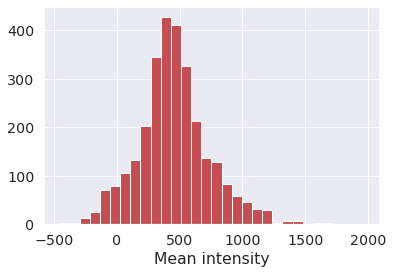

In [15]:
number_bins = 30
selected_color = 'r'
ch0_int_mean = rsp.Utilities.extract_field_from_dataframe(dataframe=df,selected_time=None,selected_field='ch0_int_mean').flatten()
plt.hist(ch0_int_mean, bins = number_bins,color = selected_color, orientation = 'vertical')
plt.xlabel('Mean intensity')
plt.show()

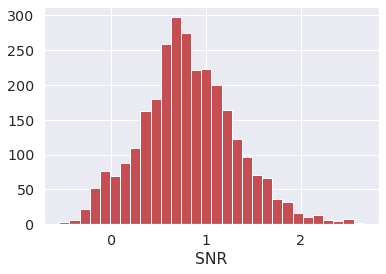

In [16]:
number_bins = 30
selected_color = 'r'
SNR = rsp.Utilities.extract_field_from_dataframe(dataframe=df,selected_time=None,selected_field='ch0_SNR').flatten()
plt.hist(SNR, bins = number_bins,color = selected_color, orientation = 'vertical')
plt.xlabel('SNR')
plt.show()